In [24]:
%matplotlib inline
from pylab import *
import numpy as np
import math
sys.path.append('..\\')
import pyban.bandit
import pyban.adversarial
import pyban.stochastic

In [25]:
ps = [0.5, 0.5]
bandits = [pyban.bandit.BernoulliBandit(p) for p in ps]
horizon = 10000 
switching_probability = 5. / horizon # probability of an adversary changing the distribution parameters
window = horizon // 100 # window size of the moving average

K = float(len(ps))
exp3_gamma = min(1, np.sqrt(K * np.log(K) / ((np.exp(1) - 1) * horizon)))

policies = [pyban.adversarial.OracleBest(),
            pyban.adversarial.OracleWorst(),
            pyban.stochastic.Random(),
            pyban.stochastic.BetaThompson(len(bandits)),
            pyban.adversarial.Exp3(len(bandits), exp3_gamma)]

rewards = np.zeros((horizon, len(ps)))
switches = []

In [26]:
for i in range(horizon):
    if switching_probability > np.random.rand(): # adversarial
        switches.append(i)
        remaining = 1.0
        for j in range(len(bandits)-1):
            p = np.random.rand()
            bandits[j].p = p * remaining
            remaining -= p
        bandits[len(bandits)-1].p = remaining
        [b.update() for b in bandits]
        ps = [b.p for b in bandits]
    rewards[i] = [b.sample() for b in bandits]
    idxs = [p.play(bandits) for p in policies]
    for j in range(len(policies)):
        policies[j].observe(rewards[i][idxs[j]], idxs[j])

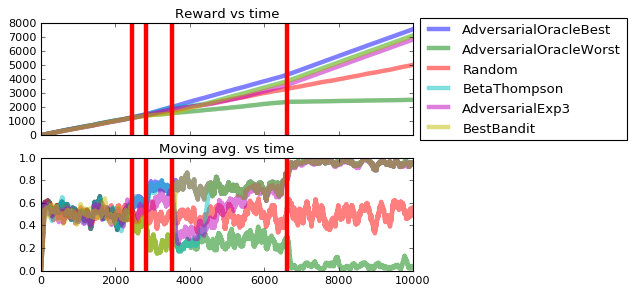

In [27]:
fig, ax = plt.subplots(2, sharex=True)
ax[0].set_title("Reward vs time")
[ax[0].plot(range(horizon), np.cumsum(p.rewards), label=p.name, linewidth=4.0, alpha=0.5) for p in policies]
bestBandit = np.argmax([np.sum(rewards[:, i]) for i in range(rewards.shape[1])])
ax[0].plot(range(horizon), np.cumsum(rewards[:, bestBandit]), label='BestBandit', linewidth=4.0, alpha=0.5)
[ax[0].axvline(x, color='r', linewidth=4.0) for x in switches]

ax[1].set_title("Moving avg. vs time")
[ax[1].plot(range(horizon), 
            np.convolve(p.rewards, np.ones(window)/window)[:horizon], 
            label=p.name, linewidth=4.0, alpha=0.5) for p in policies]
ax[1].plot(range(horizon), 
           np.convolve(rewards[:, bestBandit], np.ones(window)/window)[:horizon], 
           label='BestBandit', linewidth=4.0, alpha=0.5)
[ax[1].axvline(x, color='r', linewidth=4.0) for x in switches]

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()